In [1]:
# import modules
import os, sys
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import math

In [2]:
# normalized cross-correlation loss
class NCC:

    def __init__(self, win=None):
        self.win = win

    def loss(self, y_true, y_pred):

        Ii = y_true
        Ji = y_pred

        # get dimension of volume
        ndims = len(list(Ii.size())) - 2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

        # set window size
        win = [9] * ndims if self.win is None else self.win

        # compute filters
        sum_filt = torch.ones([1, 1, *win]).to("cuda")

        pad_no = math.floor(win[0] / 2)

        if ndims == 1:
            stride = (1)
            padding = (pad_no)
        elif ndims == 2:
            stride = (1, 1)
            padding = (pad_no, pad_no)
        else:
            stride = (1, 1, 1)
            padding = (pad_no, pad_no, pad_no)

        # get convolution function
        conv_fn = getattr(F, 'conv%dd' % ndims)

        # compute CC squares
        I2 = Ii * Ii
        J2 = Ji * Ji
        IJ = Ii * Ji

        I_sum = conv_fn(Ii, sum_filt, stride=stride, padding=padding)
        J_sum = conv_fn(Ji, sum_filt, stride=stride, padding=padding)
        I2_sum = conv_fn(I2, sum_filt, stride=stride, padding=padding)
        J2_sum = conv_fn(J2, sum_filt, stride=stride, padding=padding)
        IJ_sum = conv_fn(IJ, sum_filt, stride=stride, padding=padding)

        win_size = np.prod(win)
        u_I = I_sum / win_size
        u_J = J_sum / win_size

        cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
        I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
        J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size

        cc = cross * cross / (I_var * J_var + 1e-5)

        return -torch.mean(cc)


class MSE:

    def loss(self, y_true, y_pred):
        return torch.mean((y_true - y_pred) ** 2)


class Dice:

    def loss(self, y_true, y_pred):
        ndims = len(list(y_pred.size())) - 2
        vol_axes = list(range(2, ndims + 2))
        top = 2 * (y_true * y_pred).sum(dim=vol_axes)
        bottom = torch.clamp((y_true + y_pred).sum(dim=vol_axes), min=1e-5)
        dice = torch.mean(top / bottom)
        return -dice

    
class Grad:

    def __init__(self, penalty='l1', loss_mult=None):
        self.penalty = penalty
        self.loss_mult = loss_mult

    def loss(self, _, y_pred):
        dy = torch.abs(y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :])
        dx = torch.abs(y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :])
        dz = torch.abs(y_pred[:, :, :, :, 1:] - y_pred[:, :, :, :, :-1])

        if self.penalty == 'l2':
            dy = dy * dy
            dx = dx * dx
            dz = dz * dz

        d = torch.mean(dx) + torch.mean(dy) + torch.mean(dz)
        grad = d / 3.0

        if self.loss_mult is not None:
            grad *= self.loss_mult
        return grad

In [3]:
import torch
import torch.nn as nn
import inspect
import functools


def store_config_args(func):

    attrs, varargs, varkw, defaults = inspect.getargspec(func)

    def wrapper(self, *args, **kwargs):
        self.config = {}

        # save the default values first
        if defaults:
            for attr, val in zip(reversed(attrs), reversed(defaults)):
                self.config[attr] = val

        # handle positional args next 
        for attr, val in zip(attrs[1:], args):
            self.config[attr] = val

        # handle keyword args lastly
        if kwargs:
            for attr, val in kwargs.items():
                self.config[attr] = val

        return func(self, *args, **kwargs)
    return wrapper


class LoadableModel(nn.Module):
    def __init__(self, *args, **kwargs):
        if not hasattr(self, 'config'):
            raise RuntimeError('models that inherit from LoadableModel must decorate the '
                               'constructor with @store_config_args')
        super().__init__(*args, **kwargs)

    def save(self, path):
        sd = self.state_dict().copy()
        grid_buffers = [key for key in sd.keys() if key.endswith('.grid')]
        for key in grid_buffers:
            sd.pop(key)
        torch.save({'config': self.config, 'model_state': sd}, path)

    def load(cls, path, device):
        checkpoint = torch.load(path, map_location=torch.device(device))
        model = cls(**checkpoint['config'])
        model.load_state_dict(checkpoint['model_state'], strict=False)
        return 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf


class SpatialTransformer(nn.Module):

    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        self.register_buffer('grid', grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return nnf.grid_sample(src, new_locs, align_corners=True, mode=self.mode)

# integrates a vector field
class VecInt(nn.Module):

    def __init__(self, inshape, nsteps):
        super().__init__()

        assert nsteps >= 0, 'nsteps should be >= 0, found: %d' % nsteps
        self.nsteps = nsteps
        self.scale = 1.0 / (2 ** self.nsteps)
        self.transformer = SpatialTransformer(inshape)

    def forward(self, vec):
        vec = vec * self.scale
        for _ in range(self.nsteps):
            vec = vec + self.transformer(vec, vec)
        return vec


class ResizeTransform(nn.Module):

    def __init__(self, vel_resize, ndims):
        super().__init__()
        self.factor = 1.0 / vel_resize
        self.mode = 'linear'
        if ndims == 2:
            self.mode = 'bi' + self.mode
        elif ndims == 3:
            self.mode = 'tri' + self.mode

    def forward(self, x):
        if self.factor < 1:
            # resize first to save memory
            x = nnf.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)
            x = self.factor * x

        elif self.factor > 1:
            # multiply first to save memory
            x = self.factor * x
            x = nnf.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)

        return x

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal


class Unet(nn.Module):
    def __init__(self,
                 inshape=None,
                 infeats=None,
                 nb_features=None,
                 nb_levels=None,
                 max_pool=2,
                 feat_mult=1,
                 nb_conv_per_level=1,
                 half_res=False):

        super().__init__()

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # cache some parameters
        self.half_res = half_res

        # default encoder and decoder layer features 
        if nb_features is None:
            nb_features = default_unet_features()

        # build feature list automatically
        if isinstance(nb_features, int):
            if nb_levels is None:
                raise ValueError('must provide unet nb_levels if nb_features is an integer')
            feats = np.round(nb_features * feat_mult ** np.arange(nb_levels)).astype(int)
            nb_features = [
                np.repeat(feats[:-1], nb_conv_per_level),
                np.repeat(np.flip(feats), nb_conv_per_level)
            ]
        elif nb_levels is not None:
            raise ValueError('cannot use nb_levels if nb_features is not an integer')

        # extract full resolution decoder convolutions
        enc_nf, dec_nf = nb_features
        nb_dec_convs = len(enc_nf)
        final_convs = dec_nf[nb_dec_convs:]
        dec_nf = dec_nf[:nb_dec_convs]
        self.nb_levels = int(nb_dec_convs / nb_conv_per_level) + 1

        if isinstance(max_pool, int):
            max_pool = [max_pool] * self.nb_levels

        # cache downsampling / upsampling operations
        MaxPooling = getattr(nn, 'MaxPool%dd' % ndims)
        self.pooling = [MaxPooling(s) for s in max_pool]
        self.upsampling = [nn.Upsample(scale_factor=s, mode='nearest') for s in max_pool]

        # configure encoder (down-sampling path)
        prev_nf = infeats
        encoder_nfs = [prev_nf]
        self.encoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = enc_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.encoder.append(convs)
            encoder_nfs.append(prev_nf)

        # configure decoder (up-sampling path)
        encoder_nfs = np.flip(encoder_nfs)
        self.decoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = dec_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.decoder.append(convs)
            if not half_res or level < (self.nb_levels - 2):
                prev_nf += encoder_nfs[level]

        # any remaining convolutions
        self.remaining = nn.ModuleList()
        for num, nf in enumerate(final_convs):
            self.remaining.append(ConvBlock(ndims, prev_nf, nf))
            prev_nf = nf

        # cache final number of features
        self.final_nf = prev_nf

    def forward(self, x):

        # encoder forward pass
        x_history = [x]
        for level, convs in enumerate(self.encoder):
            for conv in convs:
                x = conv(x)
            x_history.append(x)
            x = self.pooling[level](x)

        # decoder forward pass with upsampling and concatenation
        for level, convs in enumerate(self.decoder):
            for conv in convs:
                x = conv(x)
            if not self.half_res or level < (self.nb_levels - 2):
                x = self.upsampling[level](x)
                x = torch.cat([x, x_history.pop()], dim=1)

        # remaining convs at full resolution
        for conv in self.remaining:
            x = conv(x)
        return x

# VoxelMorph network for (unsupervised) nonlinear registration between two images
class VxmDense(LoadableModel):

    def __init__(self,
                 inshape,
                 nb_unet_features=None,
                 nb_unet_levels=None,
                 unet_feat_mult=1,
                 nb_unet_conv_per_level=1,
                 int_steps=7,
                 int_downsize=2,
                 bidir=False,
                 use_probs=False,
                 src_feats=1,
                 trg_feats=1,
                 unet_half_res=False):
        
        super().__init__()

        self.training = True

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # configure core unet model
        self.unet_model = Unet(
            inshape,
            infeats=(src_feats + trg_feats),
            nb_features=nb_unet_features,
            nb_levels=nb_unet_levels,
            feat_mult=unet_feat_mult,
            nb_conv_per_level=nb_unet_conv_per_level,
            half_res=unet_half_res,
        )

        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.flow = Conv(self.unet_model.final_nf, ndims, kernel_size=3, padding=1)

        # initiate flow layer with small weights and bias
        self.flow.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        if use_probs:
            raise NotImplementedError(
                'Flow variance has not been implemented in pytorch - set use_probs to False')

        # configure optional resize layers (downsize)
        if not unet_half_res and int_steps > 0 and int_downsize > 1:
            self.resize = ResizeTransform(int_downsize, ndims)
        else:
            self.resize = None

        # resize to full resolution
        if int_steps > 0 and int_downsize > 1:
            self.fullsize = ResizeTransform(1 / int_downsize, ndims)
        else:
            self.fullsize = None

        # configure bidirectional training
        self.bidir = bidir

        # configure optional integration layer for diffeomorphic warping
        down_shape = [int(dim / int_downsize) for dim in inshape]
        self.integrate = VecInt(down_shape, int_steps) if int_steps > 0 else None

        # configure transformer
        self.transformer = SpatialTransformer(inshape)

    def forward(self, source, target, registration=False):

        # concatenate inputs and propagate unet
        x = torch.cat([source, target], dim=1)
        x = self.unet_model(x)

        # transform into flow field
        flow_field = self.flow(x)

        # resize flow for integration
        pos_flow = flow_field
        if self.resize:
            pos_flow = self.resize(pos_flow)

        preint_flow = pos_flow

        neg_flow = -pos_flow if self.bidir else None

        # integrate to produce diffeomorphic warp
        if self.integrate:
            pos_flow = self.integrate(pos_flow)
            neg_flow = self.integrate(neg_flow) if self.bidir else None

            # resize to final resolution
            if self.fullsize:
                pos_flow = self.fullsize(pos_flow)
                neg_flow = self.fullsize(neg_flow) if self.bidir else None

        # warp image with flow field
        y_source = self.transformer(source, pos_flow)
        y_target = self.transformer(target, neg_flow) if self.bidir else None

        # return non-integrated flow field 
        if not registration:
            return (y_source, y_target, preint_flow) if self.bidir else (y_source, preint_flow)
        else:
            return y_source, pos_flow


class ConvBlock(nn.Module):

    def __init__(self, ndims, in_channels, out_channels, stride=1):
        super().__init__()

        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.main = Conv(in_channels, out_channels, 3, stride, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.main(x)
        out = self.activation(out)
        return out

In [6]:
# local imports
import voxelmorph as vxm
import neurite as ne

In [7]:
# Load data
npz = np.load('tutorial_data/tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 192 x 160
print('train shape:', x_train.shape)
vol_shape = x_train.shape[1:]

train shape: (208, 192, 160)


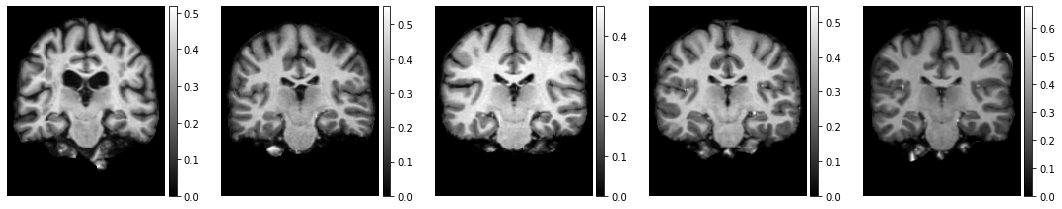

In [8]:
# extract some brain images
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [9]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         
    [32, 32, 32, 32, 32, 16]  
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

In [10]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

In [11]:
def vxm_data_generator(x_data, batch_size=32):
    
    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    nb_items = x_data.shape[0]
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # compare the resulting moved image with fixed image        
        idx1 = np.random.randint(0, nb_items, size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, nb_items, size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [12]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

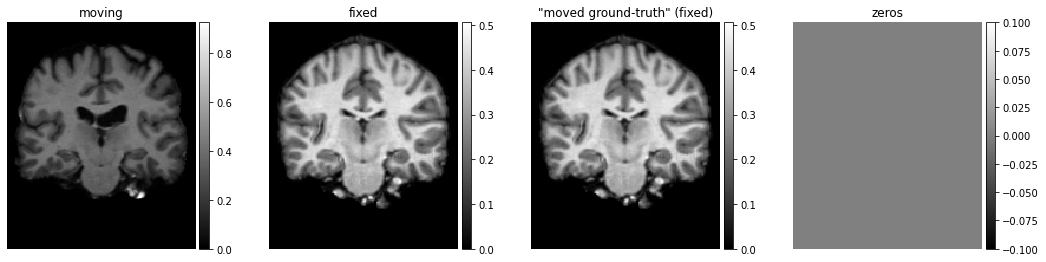

In [13]:
# get new generator
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', '"moved ground-truth" (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [14]:
nb_epochs = 20
steps_per_epoch = 20
hist1 = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/20
20/20 - 12s - loss: 0.0072 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 3.6235e-06 - 12s/epoch - 593ms/step
Epoch 2/20
20/20 - 10s - loss: 0.0068 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 8.8443e-05 - 10s/epoch - 494ms/step
Epoch 3/20
20/20 - 11s - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 6.0252e-05 - 11s/epoch - 526ms/step
Epoch 4/20
20/20 - 10s - loss: 0.0069 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 7.0559e-05 - 10s/epoch - 514ms/step
Epoch 5/20
20/20 - 10s - loss: 0.0071 - vxm_dense_transformer_loss: 0.0071 - vxm_dense_flow_loss: 7.7469e-05 - 10s/epoch - 514ms/step
Epoch 6/20
20/20 - 10s - loss: 0.0070 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 1.4829e-04 - 10s/epoch - 518ms/step
Epoch 7/20
20/20 - 10s - loss: 0.0066 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 7.6560e-04 - 10s/epoch - 523ms/step
Epoch 8/20
20/20 - 10s - loss: 0.0062 - vxm_dense_transformer_

In [21]:
# prediction
val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 0s 297ms/step


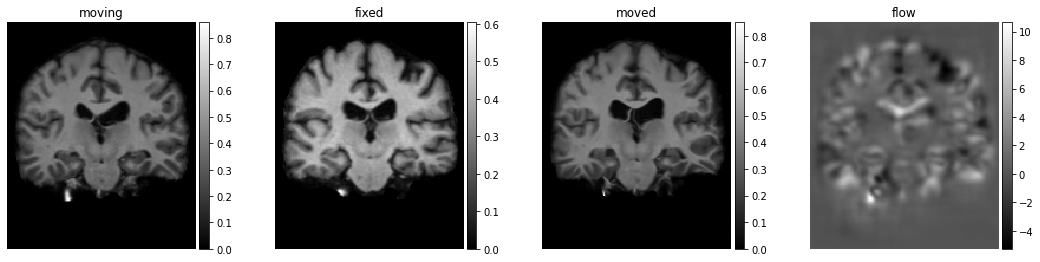

In [22]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [24]:
# prediction from pre-trained model with MSE + smoothness loss
vxm_model.load_weights('tutorial_data/brain_2d_smooth.h5')
our_val_pred = vxm_model.predict(val_input)

# prediction from pre-trained model with just MSE loss
vxm_model.load_weights('tutorial_data/brain_2d_no_smooth.h5')
mse_val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 0s 36ms/step


C:\Users\parks\AppData\Local\Temp\ipykernel_8468\4023746829.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  images = torch.as_tensor(image)


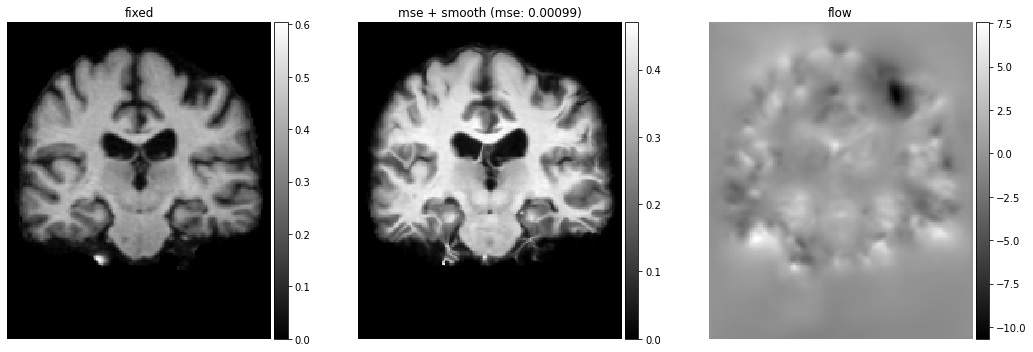

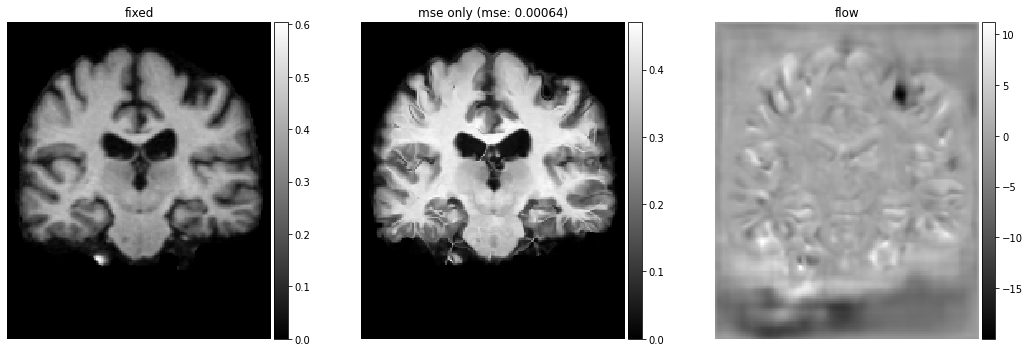

In [25]:
from torchmetrics import MeanSquaredError

def visualize_vxm_results(vols, title):
  image = [img[0, ..., 0] for img in vols]
  images = torch.as_tensor(image)
  mean_squared_error = MeanSquaredError()
  mse = mean_squared_error(images[0], images[1])
  titles = ['fixed', '%s (mse: %.5f)' % (title, mse), 'flow']
  ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
  
# visualize MSE + smoothness model output
visualize_vxm_results([val_input[1], *our_val_pred], 'mse + smooth')

# visualize MSE model output
visualize_vxm_results([val_input[1], *mse_val_pred], 'mse only')